# SDP Tightening Example

In this example, we will see how the SDPRLayer class can be used to find constraints that lead to a tight semidefinite relaxation for the simple polynomial problem in Section V-A of the [paper](https://arxiv.org/abs/2405.19309).

We start by defining the objective function and the (non-redundant) constraints:

In [32]:
import scipy.sparse as sp
import numpy as np
import torch
import matplotlib.pyplot as plt
from sdprlayer import SDPRLayer


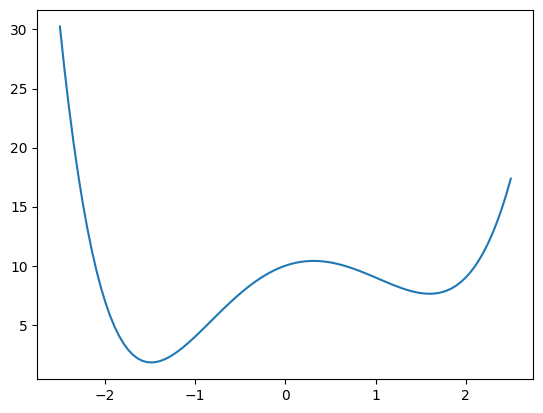

In [33]:

# Define Constraints
constraints = []
A = sp.lil_array((4, 4))  # x^2 = x*x
A[2, 0] = 1 / 2
A[0, 2] = 1 / 2
A[1, 1] = -1
constraints += [A]
A = sp.lil_array((4, 4))  # x^3 = x^2*x
A[3, 0] = 1
A[0, 3] = 1
A[1, 2] = -1
A[2, 1] = -1
constraints += [A]

# Define objective (polynomial) parameters
p_vals = np.array(
                [
                    5.0000 + 5.0,
                    1.3167 * 2,
                    -1.4481 * 3,
                    0 * 4,
                    0.2685 * 3,
                    -0.0667 * 2,
                    0.0389,
                ]
            )

# Plot Polynomial
plt.figure()
x = np.linspace(-2.5, 2.5, 100)
y = np.polyval(p_vals[::-1], x)
plt.plot(x, y)

Now we can define the SDPRLayer and run the optimization:

In [34]:
# Create SDPR Layer
layer = SDPRLayer(n_vars=4, constraints=constraints)

# Create Data matrix
def build_data_mat(p):
    Q_tch = torch.zeros((4, 4), dtype=torch.double)
    Q_tch[0, 0] = p[0]
    Q_tch[[1, 0], [0, 1]] = p[1] / 2
    Q_tch[[2, 1, 0], [0, 1, 2]] = p[2] / 3
    Q_tch[[3, 2, 1, 0], [0, 1, 2, 3]] = p[3] / 4
    Q_tch[[3, 2, 1], [1, 2, 3]] = p[4] / 3
    Q_tch[[3, 2], [2, 3]] = p[5] / 2
    Q_tch[3, 3] = p[6]
    return Q_tch
Q = build_data_mat(torch.tensor(p_vals))

# Solve problem
sdp_solver_args = {"eps": 1e-9, "verbose": True}
X, x = layer(Q, solver_args=sdp_solver_args)

------------------------------------------------------------------
	       SCS v3.2.4 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 3, constraints m: 10
cones: 	  s: psd vars: 10, ssize: 1
settings: eps_abs: 1.0e-09, eps_rel: 1.0e-09, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 5, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 2.34e+01  1.01e+00  1.61e+01 -2.53e+01  1.00e-01  1.09e-03 
   250| 9.71e-02  1.24e-02  4.90e+00  1.22e+01  3.32e-01  2.31e-03 
   500| 6.49e-02  6.28e-03  1.28e+00  1.82e+01  3.32e-01  3.49e-03 
   

We can test how tight the relaxation is using the `check_tightness` function.

In [35]:
# Check Tightness
tight, ER = SDPRLayer.check_tightness(X)
print(f"Is tight? {tight}")
print(f"Eigenvalue Ratio:  {ER}")

Is tight? False
Eigenvalue Ratio:  5.172466956454515


Based on the test, the SDP relaxation is *not tight*. However, it is possible that there are other constraints that can make this problem tight. Do find them, we first generate a set of samples from the feasible set. 

Recall that our variable in this case is of the form:
$$
\bm{x}^T = \begin{bmatrix} 1 & x & x^2 & x^3 \end{bmatrix}
$$
where $x\in\mathbb{R}$. We can therefore sample random values of $x$ and construct a list of sample vectors. It is important to make sure that samples chosen are *poised*, meaning that there are sufficient samples to represent the underlying feasible set (see paper for details).

In [36]:
# Generate a set of samples of the feasible set
n_samples = 10
samples = []
for i in range(n_samples):
    x = (np.random.rand() * 2 - 1) * 2
    samples += [np.array([1, x, x**2, x**3])]

The sample list can then be used generate a set of constraints using the `find_constraints` function:

Found 3 constraints.
Original Constraints:


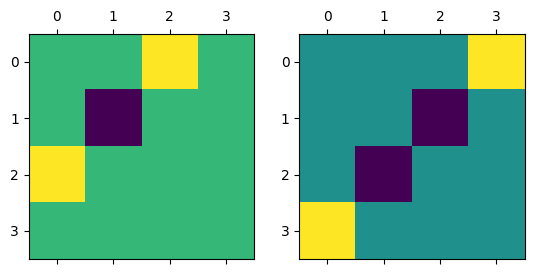

New Constraints:


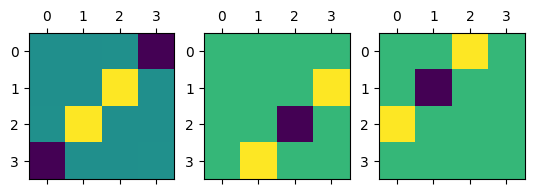

In [37]:
# Get new set of constraints
constraints_new = SDPRLayer.find_constraints(samples)
print(f"Found {len(constraints_new)} constraints.")

# Display original constraints
print("Original Constraints:")
fig, axs = plt.subplots(1,len(constraints))
for i, constr in enumerate(constraints):
    axs[i].matshow(constr.todense())
plt.show()
# Display new constraints
print("New Constraints:")
fig, axs = plt.subplots(1,len(constraints_new))
for i, constr in enumerate(constraints_new):
    axs[i].matshow(constr)
plt.show()

We have found a total of 3 constraints, two of which we already had. We can redefine the layer and run the optimization to check the tightness of the problem with the additional constraint.

In [38]:
# Create SDPR Layer
layer = SDPRLayer(n_vars=4, constraints=constraints_new)

# Solve problem
sdp_solver_args = {"eps": 1e-9, "verbose": True}
X, x = layer(Q, solver_args=sdp_solver_args)

# Check Tightness
tight, ER = SDPRLayer.check_tightness(X)
print(f"Is tight? {tight}")
print(f"Eigenvalue Ratio:  {ER}")

------------------------------------------------------------------
	       SCS v3.2.4 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 4, constraints m: 10
cones: 	  s: psd vars: 10, ssize: 1
settings: eps_abs: 1.0e-09, eps_rel: 1.0e-09, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 24, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 2.29e+01  1.01e+00  1.57e+01 -2.50e+01  1.00e-01  8.29e-04 
   250| 2.76e-02  7.92e-04  5.34e-01 -2.15e+00  3.23e-01  2.10e-03 
   500| 1.58e-04  2.26e-05  3.16e-03 -1.81e+00  3.23e-01  3.32e-03 
  

The problem is now tight with the new constraint! We can overlay the solution on the polynomial plot and see that it does correspond to the global minimum.

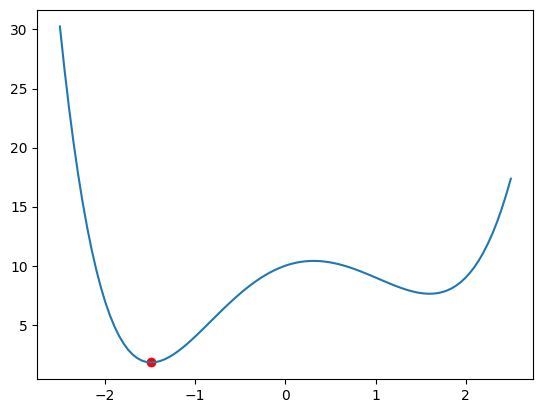

In [39]:
# Note that the homogenizing variable is stripped away
x_star = x[0,0]
y_star = torch.trace(X @ Q ).numpy()

plt.figure()
x_vals = np.linspace(-2.5, 2.5, 100)
y_vals = np.polyval(p_vals[::-1], x_vals)
plt.plot(x_vals, y_vals)
plt.scatter(x_star, y_star, color='r')
